# Objective
* 20190809:
    * Given stock returns for the last N days, we do prediction for the next N+H days, where H is the forecast horizon
    * We use single exponential smoothing to predict

In [198]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from collections import defaultdict
from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

#### Input params ##################
stk_path = "./data/VTI_20130102_20181231.csv"
H = 21
train_size = 252*3              # Use 3 years of data as train set. Note there are about 252 trading days in a year
val_size = 252                  # Use 1 year of data as validation set

alphaMax = 0.999                # alpha is a hyperparameter to tune
alphaMin = 0.001                 # alpha is a hyperparameter to tune
alphaStep = 0.001               # alpha is a hyperparameter to tune

fontsize = 14
ticklabelsize = 14
####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 1008


In [199]:
print("We will start forecasting on day %d" % (train_val_size+1))

We will start forecasting on day 1009


# Common functions

In [200]:
def get_smape(y_true, y_pred):
    """
    Compute symmetric mean absolute percentage error
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

def exponential_smoothing(series, H, alpha=0.5):
    """
    Given a series and alpha, return series of smoothed points
    Set S_2 = y_1 (there is no S_1), and
    S_t = alpha * y_t-1 + (1-alpha) * S_t-1, where t >= 3. Note t starts from 1.
    Forecast S_t+1 = alpha * y_origin + (1-alpha) * S_t, where y_origin is the last known data point    
    Inputs
        series: series to forecast
        alpha : smoothing constant. 
                When alpha is close to 1, dampening is quick. 
                When alpha is close to 0, dampening is slow
        H     : forecast horizon
    Outputs
        result: the predictions. The length of result is H
    """
    result = [0, series[0]] # initialization
    for n in range(1, len(series)+H-1):
        if n >= len(series): # we are forecasting
            result.append(alpha * series[-1] + (1 - alpha) * result[n])
        else:
            result.append(alpha * series[n] + (1 - alpha) * result[n]) 
            # result[2] is the forecast using series[1],  ie. result[2] is the estimate of series[2]
    return result[len(series):len(series)+H]

def get_error_metrics(series, train_size, H, alpha):
    """
    Given a series consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        series     : series to forecast, with length = (train_size + val_size)
        train_size : length of series to use as train ie. train set is series[:train_size]
        H          : forecast horizon
    Outputs
        mean of rmse, mean of mape, mean of mae
    """
    # Predict using single exponential smoothing, and compute error metrics also
    rmse = [] # root mean square error
    mape = [] # mean absolute percentage error
    mae = []  # mean absolute error
    smape = []  # symmetric mean absolute percentage error
    preds_dict = {}
    
    for i in range(train_size, len(series)-H, int(H/2)):
        preds_list = exponential_smoothing(series[i-train_size:i], H, alpha)
        
        rmse.append(get_rmse(series[i:i+H], preds_list))
        mape.append(get_mape(series[i:i+H], preds_list))
        mae.append(get_mae(series[i:i+H], preds_list))
        smape.append(get_smape(series[i:i+H], preds_list))
        preds_dict[i] = preds_list
    
    return np.mean(rmse), np.mean(mape), np.mean(mae), np.mean(smape), preds_dict    
    
def hyperpram_tune_alpha(series, train_size, H):
    """
    Given a series, tune hyperparameter alpha, fit and predict
    Inputs
        series     : series to forecast, with length = (train_size + val_size)
        train_size : length of series to use as train ie. train set is series[:train_size]
        H          : forecast horizon
    Outputs
        optimum hyperparameters, error metrics dataframe
    """
    alpha_err_dict = defaultdict(list)
    alpha = alphaMin
    while alpha <= alphaMax:
        rmse_mean, mape_mean, mae_mean, smape_mean, _ = get_error_metrics(series, train_size, H, alpha)
        
        # Append alpha
        alpha_err_dict['alpha'].append(alpha)
    
        # Compute error metrics
        alpha_err_dict['rmse'].append(rmse_mean)
        alpha_err_dict['mape'].append(mape_mean)
        alpha_err_dict['mae'].append(mae_mean)
        alpha_err_dict['smape'].append(smape_mean)
        
        # Increase alpha by one step
        alpha = alpha + alphaStep
    
    # Convert to dataframe
    alpha_err_df = pd.DataFrame(alpha_err_dict)
    
    # Get min RMSE
    rmse_min = alpha_err_df['rmse'].min()
    
    return alpha_err_df[alpha_err_df['rmse'] == rmse_min]['alpha'].values[0], alpha_err_df

# Load data

In [201]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume
0,2013-01-02,74.529999,75.150002,74.500000,75.139999,66.997757,5037200
1,2013-01-03,75.120003,75.370003,74.839996,75.029999,66.899689,2634600
2,2013-01-04,75.139999,75.519997,74.989998,75.410004,67.238510,2512900
3,2013-01-07,75.180000,75.279999,74.949997,75.209999,67.060173,2511200
4,2013-01-08,75.110001,75.180000,74.699997,75.010002,66.881859,1407900
5,2013-01-09,75.190002,75.410004,75.110001,75.239998,67.086937,1421900
6,2013-01-10,75.620003,75.769997,75.220001,75.760002,67.550591,1403700
7,2013-01-11,75.760002,75.800003,75.510002,75.769997,67.559486,1248500
8,2013-01-14,75.750000,75.800003,75.440002,75.690002,67.488159,2745100
9,2013-01-15,75.400002,75.889999,75.339996,75.830002,67.612984,1109100


In [202]:
df['date'].min(), df['date'].max() 

(Timestamp('2013-01-02 00:00:00'), Timestamp('2018-12-28 00:00:00'))

Text(0, 0.5, 'USD')

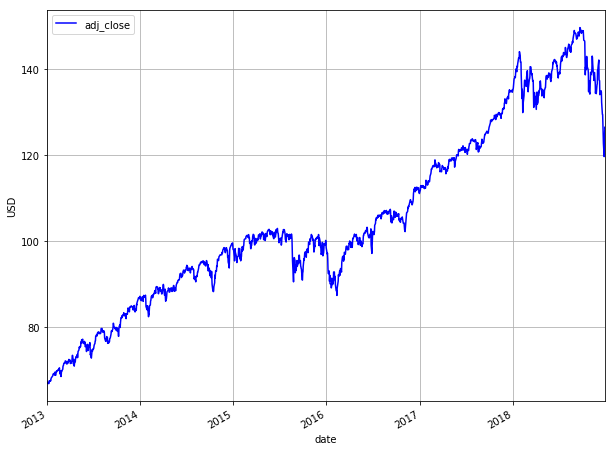

In [203]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Get Stock Returns

In [204]:
df['returns'] = df['adj_close'].pct_change() * 100
df.loc[0, 'returns'] = 0 # set the first value of returns to be 0 for simplicity
df.head()

,date,open,high,low,close,adj_close,volume,returns
0,2013-01-02,74.529999,75.150002,74.500000,75.139999,66.997757,5037200,0.000000
1,2013-01-03,75.120003,75.370003,74.839996,75.029999,66.899689,2634600,-0.146375
2,2013-01-04,75.139999,75.519997,74.989998,75.410004,67.238510,2512900,0.506461
3,2013-01-07,75.180000,75.279999,74.949997,75.209999,67.060173,2511200,-0.265230
4,2013-01-08,75.110001,75.180000,74.699997,75.010002,66.881859,1407900,-0.265901


Text(0, 0.5, 'returns')

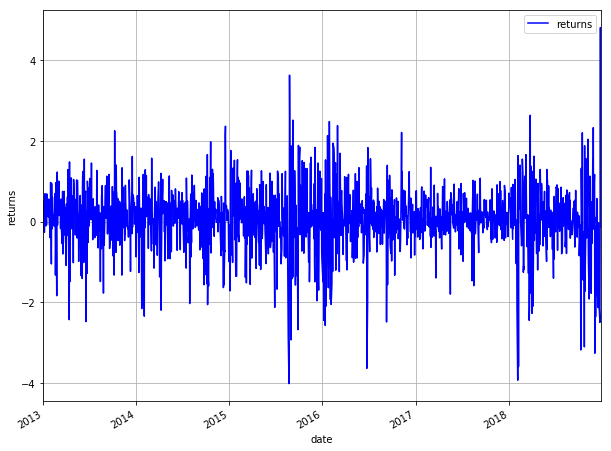

In [205]:
# Plot returns over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = df.plot(x='date', y='returns', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("returns")

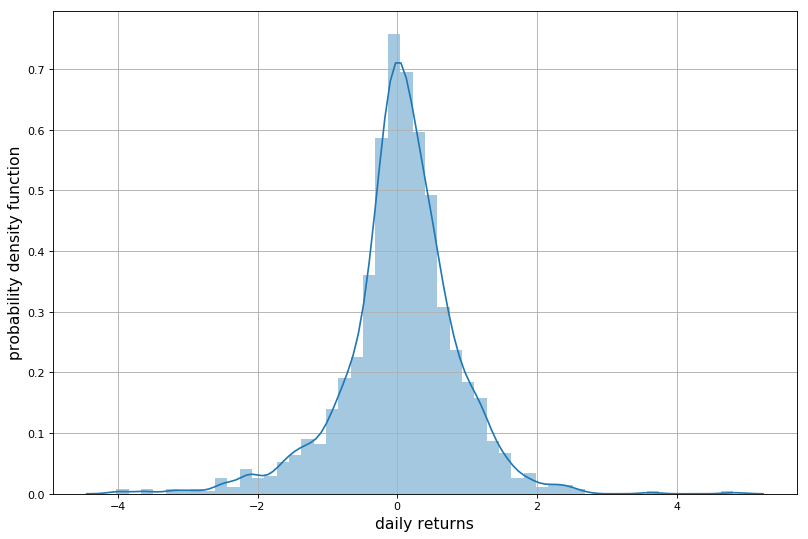

In [206]:
# Plot distribution of returns
plt.figure(figsize=(12, 8), dpi=80)
ax = sns.distplot(df['returns'][1:])
ax.grid()
ax.set_xlabel('daily returns', fontsize = 14)
ax.set_ylabel("probability density function", fontsize = 14)
matplotlib.rcParams.update({'font.size': 14})


# Predict for a specific H (forecast horizon) and a specific date

In [207]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df.iloc[i]['date'], H))

Predicting on day 1008, date 2017-01-03 00:00:00, with forecast horizon H = 21


In [208]:
# Predict
preds_list = exponential_smoothing(df['returns'][i-train_val_size:i].values, H)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df[i:i+H]['returns'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the MAPE is %f" % (H, i, df['date'][i], get_mape(df[i:i+H]['returns'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the SMAPE is %f" % (H, i, df['date'][i], get_smape(df[i:i+H]['returns'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the MAE is %f" % (H, i, df['date'][i], get_mae(df[i:i+H]['returns'], preds_list)))

For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 0.619486
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the MAPE is 362.351962
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the SMAPE is 131.797581
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the MAE is 0.489914


(736269.0, 736388.0)

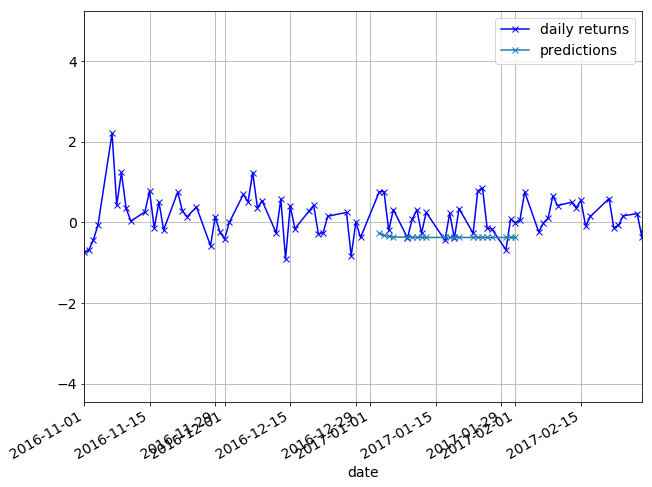

In [209]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = df.plot(x='date', y='returns', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
# ax.set_ylabel("daily returns")
ax.legend(['daily returns', 'predictions'])
# ax.set_ylim([105, 120])
ax.set_xlim([date(2016, 11, 1), date(2017, 2, 28)])

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - alpha

In [210]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df.iloc[i]['date'], H))

Predicting on day 1008, date 2017-01-03 00:00:00, with forecast horizon H = 21


In [211]:
# Get optimum hyperparams
alpha_opt, alpha_err_df = hyperpram_tune_alpha(df['returns'][i-train_val_size:i].values, train_size, H)
print("alpha_opt = " + str(alpha_opt))
alpha_err_df

/Users/yibin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


alpha_opt = 0.004


,alpha,rmse,mape,mae,smape
0,0.001,0.828871,inf,0.648501,153.174703
1,0.002,0.787365,inf,0.608359,164.978068
2,0.003,0.778704,inf,0.600222,173.313318
3,0.004,0.778257,inf,0.598778,174.344987
4,0.005,0.779270,inf,0.599632,173.385900
5,0.006,0.780431,inf,0.600824,171.652161
6,0.007,0.781603,inf,0.601958,169.606181
7,0.008,0.782825,inf,0.603043,167.678681
8,0.009,0.784133,inf,0.604083,165.989836
9,0.010,0.785545,inf,0.605293,164.511685


In [212]:
# Predict
preds_list = exponential_smoothing(df['returns'][i-train_val_size:i].values, H, alpha_opt)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df[i:i+H]['returns'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the MAPE is %f" % (H, i, df['date'][i], get_mape(df[i:i+H]['returns'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the SMAPE is %f" % (H, i, df['date'][i], get_smape(df[i:i+H]['returns'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the MAE is %f" % (H, i, df['date'][i], get_mae(df[i:i+H]['returns'], preds_list)))

For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 0.437055
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the MAPE is 105.748926
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the SMAPE is 177.547197
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the MAE is 0.363747


(736269.0, 736388.0)

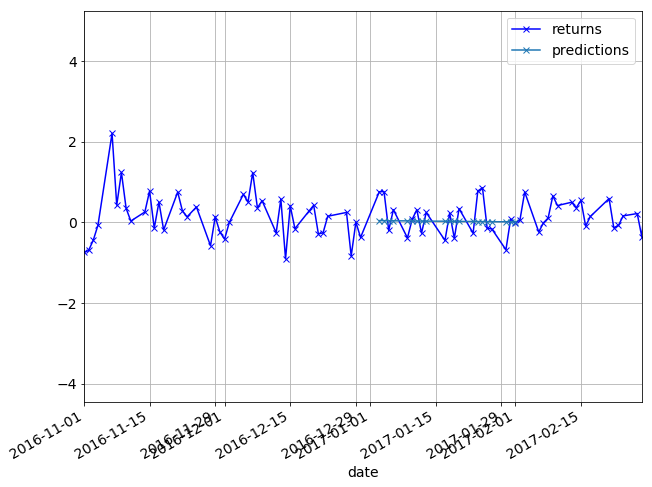

In [213]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = df.plot(x='date', y='returns', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
# ax.set_ylabel("USD")
ax.legend(['returns', 'predictions'])
# ax.set_ylim([105, 120])
ax.set_xlim([date(2016, 11, 1), date(2017, 2, 28)])

# Predict for a specific H (forecast horizon), and various dates, using model trained in previous step

In [214]:
alpha_opt = 0.004

In [215]:
# Predict and compute error metrics also
rmse = [] # root mean square error
mape = [] # mean absolute percentage error
mae = []  # mean absolute error
smape = [] # symmetric mean absolute percentage error
preds_dict = {}
i_list = range(train_val_size, train_val_size+84*5+42+1, 42)
for i in i_list:
    print("Predicting on day %d, date %s" % (i, df.iloc[i]['date']))
        
    preds_list = exponential_smoothing(df['returns'][i-train_val_size:i].values, H, alpha_opt)
    
    # Collect the predictions
    preds_dict[i] = preds_list
    
    # Compute error metrics
    rmse.append(get_rmse(df[i:i+H]['returns'], preds_list))
    mape.append(get_mape(df[i:i+H]['returns'], preds_list))
    mae.append(get_mae(df[i:i+H]['returns'], preds_list))
    smape.append(get_smape(df[i:i+H]['returns'], preds_list))

print("Altogether we made %d forecasts, each of length %d days" % (len(rmse), H))

Predicting on day 1008, date 2017-01-03 00:00:00
Predicting on day 1050, date 2017-03-06 00:00:00
Predicting on day 1092, date 2017-05-04 00:00:00
Predicting on day 1134, date 2017-07-05 00:00:00
Predicting on day 1176, date 2017-09-01 00:00:00
Predicting on day 1218, date 2017-11-01 00:00:00
Predicting on day 1260, date 2018-01-03 00:00:00
Predicting on day 1302, date 2018-03-06 00:00:00
Predicting on day 1344, date 2018-05-04 00:00:00
Predicting on day 1386, date 2018-07-05 00:00:00
Predicting on day 1428, date 2018-09-04 00:00:00
Predicting on day 1470, date 2018-11-01 00:00:00
Altogether we made 12 forecasts, each of length 21 days


/Users/yibin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


In [216]:
print("For forecast horizon %d, the mean RMSE is %f" % (H, np.mean(rmse)))
print("For forecast horizon %d, the mean MAPE is %f" % (H, np.mean(mape)))
print("For forecast horizon %d, the mean SMAPE is %f" % (H, np.mean(smape)))
print("For forecast horizon %d, the mean MAE is %f" % (H, np.mean(mae)))

For forecast horizon 21, the mean RMSE is 0.591140
For forecast horizon 21, the mean MAPE is inf
For forecast horizon 21, the mean SMAPE is 157.773141
For forecast horizon 21, the mean MAE is 0.454887


In [217]:
results_final_no_tune = pd.DataFrame({'day': i_list,
                                      'alpha_opt': [alpha_opt]*len(i_list),
                                      'rmse': rmse,
                                      'mape': mape,
                                      'mae': mae,
                                      'smape': smape})
results_final_no_tune

,day,alpha_opt,rmse,mape,mae,smape
0,1008,0.004,0.437055,105.748926,0.363747,177.547197
1,1050,0.004,0.463835,149.165613,0.331965,158.174328
2,1092,0.004,0.534074,130.623075,0.361442,162.615280
3,1134,0.004,0.356017,inf,0.243137,143.743654
4,1176,0.004,0.351072,116.903997,0.245548,125.851210
5,1218,0.004,0.401390,inf,0.293454,148.022980
6,1260,0.004,0.543968,118.608786,0.447096,158.656579
7,1302,0.004,1.321018,108.212649,0.993205,163.594127
8,1344,0.004,0.658484,88.506403,0.529481,161.505792
9,1386,0.004,0.538989,96.279361,0.455019,167.445376


(736330.0, 737059.0)

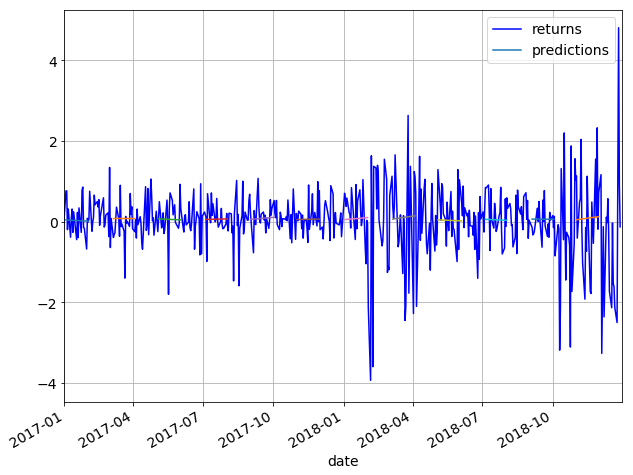

In [218]:
# Plot the predictions, and zoom in
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='returns', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
# ax.set_ylabel("USD")
ax.legend(['returns', 'predictions'])
# ax.set_ylim([105, 150])
ax.set_xlim([date(2017, 1, 1), date(2018, 12, 31)])

# Predict for a specific H (forecast horizon), and various dates, tuning model for every prediction

In [219]:
# Predict and compute error metrics also
rmse = [] # root mean square error
mape = [] # mean absolute percentage error
mae = []  # mean absolute error
smape = [] # symmetric mean absolute percentage error
alpha_opt_list = [] # optimum hyperparamters
preds_dict = {}
i_list = range(train_val_size, train_val_size+84*5+42+1, 42)
for i in i_list:
    print("Predicting on day %d, date %s" % (i, df.iloc[i]['date']))
    
    # Get optimum hyperparams
    alpha_opt, alpha_err_df = hyperpram_tune_alpha(df['returns'][i-train_val_size:i].values, train_size, H)
        
    preds_list = exponential_smoothing(df['returns'][i-train_val_size:i].values, H, alpha_opt)
    
    # Collect the predictions
    preds_dict[i] = preds_list
    
    # Compute error metrics
    rmse.append(get_rmse(df[i:i+H]['returns'], preds_list))
    mape.append(get_mape(df[i:i+H]['returns'], preds_list))
    mae.append(get_mae(df[i:i+H]['returns'], preds_list))
    smape.append(get_smape(df[i:i+H]['returns'], preds_list))
    alpha_opt_list.append(alpha_opt)

print("Altogether we made %d forecasts, each of length %d days" % (len(rmse), H))

Predicting on day 1008, date 2017-01-03 00:00:00


/Users/yibin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


Predicting on day 1050, date 2017-03-06 00:00:00
Predicting on day 1092, date 2017-05-04 00:00:00
Predicting on day 1134, date 2017-07-05 00:00:00
Predicting on day 1176, date 2017-09-01 00:00:00
Predicting on day 1218, date 2017-11-01 00:00:00
Predicting on day 1260, date 2018-01-03 00:00:00
Predicting on day 1302, date 2018-03-06 00:00:00
Predicting on day 1344, date 2018-05-04 00:00:00
Predicting on day 1386, date 2018-07-05 00:00:00
Predicting on day 1428, date 2018-09-04 00:00:00
Predicting on day 1470, date 2018-11-01 00:00:00
Altogether we made 12 forecasts, each of length 21 days


In [220]:
print("For forecast horizon %d, the mean RMSE is %f" % (H, np.mean(rmse)))
print("For forecast horizon %d, the mean MAPE is %f" % (H, np.mean(mape)))
print("For forecast horizon %d, the mean SMAPE is %f" % (H, np.mean(smape)))
print("For forecast horizon %d, the mean MAE is %f" % (H, np.mean(mae)))

For forecast horizon 21, the mean RMSE is 0.590713
For forecast horizon 21, the mean MAPE is inf
For forecast horizon 21, the mean SMAPE is 157.143776
For forecast horizon 21, the mean MAE is 0.454658


In [221]:
# results
results_final = pd.DataFrame({'day': i_list,
                              'alpha_opt': alpha_opt_list,
                              'rmse': rmse,
                              'mape': mape,
                              'mae': mae,
                              'smape': smape})
results_final

,day,alpha_opt,rmse,mape,mae,smape
0,1008,0.004,0.437055,105.748926,0.363747,177.547197
1,1050,0.004,0.463835,149.165613,0.331965,158.174328
2,1092,0.003,0.531978,148.974428,0.359577,153.197398
3,1134,0.003,0.355972,inf,0.242673,143.970690
4,1176,0.006,0.349034,121.524523,0.244378,124.512267
5,1218,0.005,0.399596,inf,0.293828,146.126622
6,1260,0.005,0.540675,127.957747,0.445959,153.745963
7,1302,0.005,1.323618,109.325031,0.994431,161.141675
8,1344,0.004,0.658484,88.506403,0.529481,161.505792
9,1386,0.006,0.541887,96.694156,0.457634,175.477523


(736330.0, 737059.0)

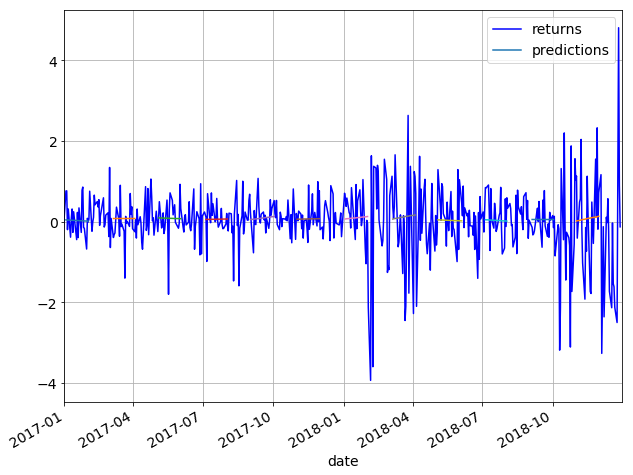

In [222]:
# Plot the predictions, and zoom in
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='returns', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
# ax.set_ylabel("USD")
ax.legend(['returns', 'predictions'])
# ax.set_ylim([105, 150])
ax.set_xlim([date(2017, 1, 1), date(2018, 12, 31)])

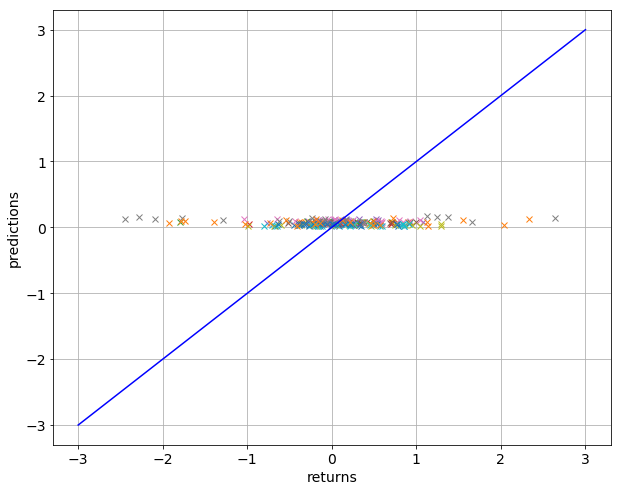

In [229]:
# Plot scatter plot of actual values vs. predictions
for key in preds_dict:
    plt.plot(df['returns'][key:key+H], preds_dict[key], 'x')
    
plt.plot(range(-3, 4, 1), range(-3, 4, 1), 'b-')
    
plt.xlabel('returns')
plt.ylabel('predictions')
plt.grid()

# Findings

Single exponential smoothing does not predict stock returns well.